# Compare ESCO occupations by their ESCO skills

We used **NLP-adjusted overlap** to make flexible comparisons of occupations' skills sets. By skills we refer to all of the 13,000+ items from the ESCO skills pillar. We are agnostic to the particular category of the skills pillar items – for example, we may compare a 'skill' item with a 'knowledge' item. 

In this notebook, for each occupation pair, we calculate:
1. The NLP-adjusted overlap of essential skills sets
2. The NLP-adjusted overlap that also includes optional skills (specifically, we include optional skills of the origin occupation).

For more information about the NLP-adjusted overlap, see the Mapping Career Causeways [research report](https://www.nesta.org.uk/report/mapping-career-causeways-supporting-workers-risk/).

# 0. Import dependencies and inputs

In [2]:
%run ../notebook_preamble.ipy

import sys
from itertools import combinations_with_replacement

In [5]:
# Load embeddings of skills descriptions
embeddings = np.load(data_folder + 'interim/embeddings/embeddings_skills_description_SBERT.npy')

# Load occupation and skills data
occupations = pd.read_csv(data_folder + 'processed/ESCO_occupations.csv')
skills = pd.read_csv(data_folder + 'processed/ESCO_skills.csv')
occupation_to_skills = pd.read_csv(data_folder + 'processed/ESCO_occupation_to_skills.csv')

# ESCO occupation hierarchy (use to select only the "top level" ESCO occupations)
occ_hierarchy = pd.read_csv(data_folder + 'processed/ESCO_occupational_hierarchy/ESCO_occupational_hierarchy.csv')

# Import dataframe with the skills IDs for each occupation
node_to_essential_items = pickle.load(open(data_folder + 'processed/occupation_to_essential_skills.pickle','rb'))
node_to_all_items = pickle.load(open(data_folder + 'processed/occupation_to_all_skills.pickle','rb'))

n_occupations = len(occupations)
print(n_occupations)

2942


# 1. Essential skills comparison

At the most granular level of detail, we compared occupations in terms of their essential skills. Methods
for measuring the overlap between two sets of discrete elements typically assume that each unique element is
completely different from the others. We expected that this assumption may not always hold for the 13,000 ESCO skills, as we might encounter closely related skills or even skills that are practically synonyms (e.g. skills to ‘maintain
ship logs’ and to ‘maintain voyage logs’). Therefore, we used methods from NLP – a subfield of machine learning – and developed a novel approach to measure the extent to which two occupations share similar skills.

In [7]:
# Choose sectors to compare (here, sectors correspond simply the major ISCO-08 groups; we use all sectors)
sectors = node_to_essential_items.sector.unique()
combinations_of_sectors = list(combinations_with_replacement(sectors,2))
print(len(combinations_of_sectors))

55


In [8]:
# Perform the comparison!
comp_essential = compare_nodes_utils.CompareSectors(
    node_to_essential_items,
    embeddings, 
    combinations_of_sectors,
    metric='cosine',
    symmetric=False)

t = time()
comp_essential.run_comparisons(dump=False)
comp_essential.collect_comparisons()
t_elapsed = time()-t
print('===============')
print(f"Total time elapsed: {t_elapsed:.0f} seconds")


(2, 2)


/Users/karliskanders/Documents/mapping-career-causeways/mapping_career_causeways/compare_nodes_utils.py:427: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/karliskanders/Documents/mapping-career-causeways/mapping_career_causeways/compare_nodes_utils.py:429: RuntimeWarning:

divide by zero encountered in double_scalars



94.64
(2, 8)
54.34
(2, 7)
57.60
(2, 3)
97.44
(2, 5)
36.05
(2, 1)
52.39
(2, 6)
16.89
(2, 4)
20.28
(2, 0)
12.19
(2, 9)
19.75
(8, 8)
9.39
(8, 7)
14.99
(8, 3)
32.01
(8, 5)
10.74
(8, 1)
16.18
(8, 6)
4.00
(8, 4)
5.32
(8, 0)
2.50
(8, 9)
4.58
(7, 7)
12.26
(7, 3)
35.98
(7, 5)
11.89
(7, 1)
19.25
(7, 6)
4.76
(7, 4)
6.14
(7, 0)
2.93
(7, 9)
5.43
(3, 3)
48.20
(3, 5)
24.55
(3, 1)
35.67
(3, 6)
11.89
(3, 4)
14.61
(3, 0)
8.55
(3, 9)
13.46
(5, 5)
4.54
(5, 1)
11.17
(5, 6)
2.63
(5, 4)
3.31
(5, 0)
1.43
(5, 9)
2.99
(1, 1)
13.68
(1, 6)
4.55
(1, 4)
5.61
(1, 0)
2.63
(1, 9)
5.32
(6, 6)
0.35
(6, 4)
1.13
(6, 0)
0.26
(6, 9)
0.82
(4, 4)
0.74
(4, 0)
0.49
(4, 9)
1.34
(0, 0)
0.04
(0, 9)
0.41
(9, 9)
0.53
Total time elapsed: 884 seconds


On a MacBook Pro (i5 CPU), the calculations take about 15 minutes.

## 1.1 Check examples


In [10]:
# Similarity matrix
W = comp_essential.D.copy()
# Infinite values may arise in a few cases where the destination occupation has no specified essential skills
# (and hence the denominator for those calculations is 0)
W[np.isinf(W)] = 0

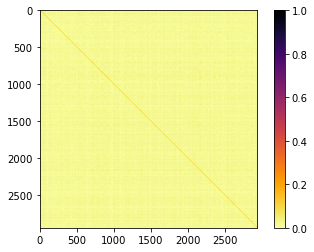

In [11]:
# Visualise the similarity matrix
plt.imshow(W, cmap='inferno_r')
plt.colorbar()
plt.show()

Asymmetry test: True


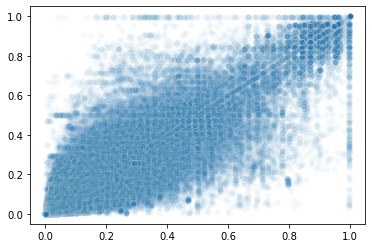

In [12]:
# Check if the matrix is asymmetric and visualise
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

print(f"Asymmetry test: {check_symmetric(W)==False}")

sim_i_to_j = []
sim_j_to_i = []
for i in range(n_occupations):
    for j in range(i,n_occupations):
        sim_i_to_j.append(W[i,j])
        sim_j_to_i.append(W[j,i])

sns.scatterplot(sim_i_to_j, sim_j_to_i, alpha=0.05)
plt.show()

In [14]:
# Check the most similar occupations for a random occupation
compare_nodes_utils.find_closest(None, W, comp_essential.nodes).head(7)

,id,occupation,items_list,sector,similarity
1183,1183,surveying technician,"[95, 940, 1514, 1801, 1851, 2477, 2974, 3090, ...",3,1.000000
458,458,cadastral technician,"[940, 2477, 2974, 3090, 3607, 5436, 5500, 5702...",2,0.749884
803,803,hydrographic surveyor,"[95, 940, 1514, 1801, 2345, 2477, 3571, 5436, ...",2,0.714679
2540,2540,land surveyor,"[95, 940, 1514, 1705, 1801, 1851, 2477, 3090, ...",2,0.687636
1234,1234,hydrographic surveying technician,"[95, 940, 1514, 1801, 2345, 2477, 3571, 4862, ...",3,0.618535
1871,1871,mine surveying technician,"[940, 1123, 1162, 2869, 7149, 7773, 9266, 11894]",3,0.502096
2530,2530,civil engineer,"[1705, 1851, 3535, 4223, 4478, 4781, 6117, 695...",2,0.405283


## 1.2 Export the similarity matrix

In [15]:
# Save the similarity matrix & the descriptions of the matrix rows/columns
np.save(data_folder + 'processed/sim_matrices/OccupationSimilarity_EssentialSkillsDescription_asymmetric.npy', W)
comp_essential.nodes.to_csv(data_folder + 'processed/sim_matrices/OccupationSimilarity_EssentialSkillsDescription_Nodes.csv')


# 2. Optional skills comparison

Some workers may also possess skills that have been designated as optional by ESCO. To take this into account, we evaluated another version of the NLP-adjusted overlap that also includes the optional skills of the origin occupation. We compared the **full skills set of the origin occupation**, featuring **both essential and optional skills**, and the **essential skills set of the destination occupation**. In this way, we have assumed that workers are only required to fill the essential destination job requirements, and thus this similarity measure will always be equal to or higher than the NLP-adjusted overlap of essential skills only

## 2.1 Prepare data for comparison

In [16]:
# Set up "origin" sector and "destination" sectors

# Origin nodes
from_node_to_items =  node_to_all_items.copy()
from_node_to_items.sector = 'origin'

# Destination nodes
to_node_to_items =  node_to_essential_items.copy()
to_node_to_items.sector = 'destination'
to_node_to_items.id = to_node_to_items.id + n_occupations

# Combine all into one dataframe
node_to_items = pd.concat([from_node_to_items, to_node_to_items]).reset_index(drop=True)

# Set up the combination of sectors to check
combos = [('origin','destination')]

## 2.1 Compare and check examples

In [17]:
# Perform the comparison!
comp_all_to_essential = compare_nodes_utils.CompareSectors(
    node_to_items,
    embeddings, 
    combos,
    metric='cosine',
    symmetric=False)

t = time()
comp_all_to_essential.run_comparisons(dump=False)
comp_all_to_essential.collect_comparisons()
t_elapsed = time()-t
print('===============')
print(f"Total time elapsed: {t_elapsed:.0f} seconds")


('origin', 'destination')


/Users/karliskanders/Documents/mapping-career-causeways/mapping_career_causeways/compare_nodes_utils.py:427: RuntimeWarning:

divide by zero encountered in double_scalars



5255.37
Total time elapsed: 5277 seconds


On a MacBook Pro (i5 CPU), the calculations take about 1.5 hrs.

In [20]:
# Select only the edges from the origin to the destination occupations
W_all_to_essential = comp_all_to_essential.D
i_edges = [edge[0] for edge in comp_all_to_essential.real_edge_list]
from_edges = np.array(comp_all_to_essential.real_edge_list)[np.where(np.array(i_edges)<n_occupations)[0]]

W_from_all_to_essential = np.zeros((n_occupations,n_occupations))
for edge in from_edges:
    W_from_all_to_essential[edge[0], edge[1]-n_occupations] = W_all_to_essential[edge[0],edge[1]]

# Take care of nulls
W_from_all_to_essential[np.isinf(W_from_all_to_essential)] = 0
W_from_all_to_essential.shape

(2942, 2942)

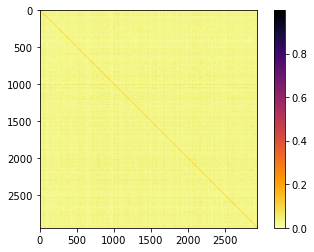

In [21]:
# Visualise the similarity matrix
plt.imshow(W_from_all_to_essential, cmap = 'inferno_r')
plt.colorbar()
plt.show()

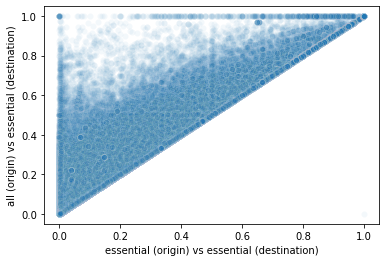

In [22]:
# Compare both similarity measures
# (Check that the measure using optional skills is always greater or equal than the essential measure)
sns.scatterplot(W.flatten(),
                W_from_all_to_essential.flatten(),
                alpha=0.05)
plt.xlabel('essential (origin) vs essential (destination)')
plt.ylabel('all (origin) vs essential (destination)')
plt.show()

## 2.2 Export the similarity matrix

In [27]:
np.save(data_folder + 'processed/sim_matrices/OccupationSimilarity_AllToEssentialSkillsDescription_asymmetric.npy', W_from_all_to_essential)
